# Neural Network for Fraud Detection

Cost-sensitive training with threshold optimization

This notebook covers loading data, preprocessing, model building, training, cost-sensitive weighting, threshold optimization, evaluation metrics, confusion matrix, and exporting the model.

In [39]:
# Imports and setup
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef
)

In [40]:
# Load the dataset and display its shape and head data
path = '../Data/Fraud_Cleaned.csv'
df = pd.read_csv(path)
print(f"Loaded data with shape: {df.shape}")
df.head()

Loaded data with shape: (498050, 10)


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0


In [41]:
# Print the Dataset fraud distribution
print("Fraud proportion:")
print(df['fraud'].value_counts(normalize=True))

Fraud proportion:
fraud
0    0.952366
1    0.047634
Name: proportion, dtype: float64


In [42]:
# Splits the data set in to a Training set (70%), Validation set (15%) and Test set (15%). For NN features are scaled. The random state 42 ensure that all models are trained and evaluated on the same data.
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (348635, 9), Val: (74707, 9), Test: (74708, 9)


In [43]:
# Cost-sensitive class weights (FP cost = 5× FN cost)
class_weights = {0: 5, 1: 1}
print(f"Class weights: {class_weights}")

Class weights: {0: 5, 1: 1}


In [44]:
# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                640       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-traina

In [45]:
# Train the model with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', patience=10, mode='max', restore_best_weights=True
    )
]

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
)

Epoch 1/100
5448/5448 [==============================] - 14s 2ms/step - loss: 0.1359 - auc: 0.9627 - val_loss: 0.0426 - val_auc: 0.9957
Epoch 2/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0725 - auc: 0.9915 - val_loss: 0.0384 - val_auc: 0.9975
Epoch 3/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0666 - auc: 0.9926 - val_loss: 0.0363 - val_auc: 0.9978
Epoch 4/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0648 - auc: 0.9926 - val_loss: 0.0355 - val_auc: 0.9981
Epoch 5/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0635 - auc: 0.9928 - val_loss: 0.0404 - val_auc: 0.9967
Epoch 6/100
5448/5448 [==============================] - 13s 2ms/step - loss: 0.0627 - auc: 0.9931 - val_loss: 0.0488 - val_auc: 0.9965
Epoch 7/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0621 - auc: 0.9936 - val_loss: 0.0337 - val_auc: 0.9973
Epoch 8/100
5448/5448 [=========================

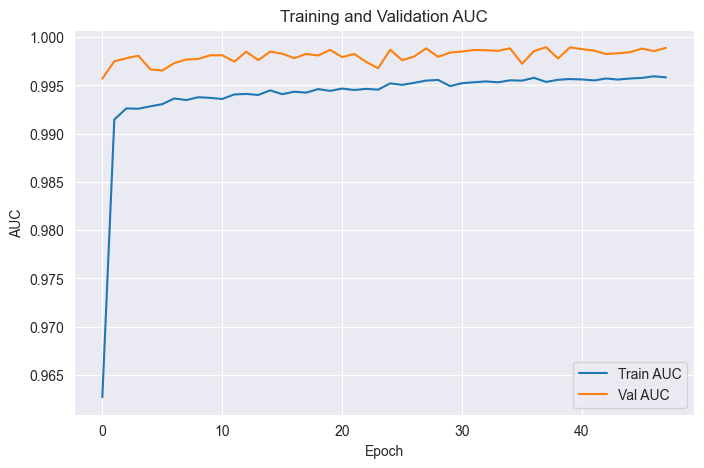

In [46]:
# Plot AUC history
plt.figure(figsize=(8, 5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

2335/2335 [==============================] - 2s 944us/step


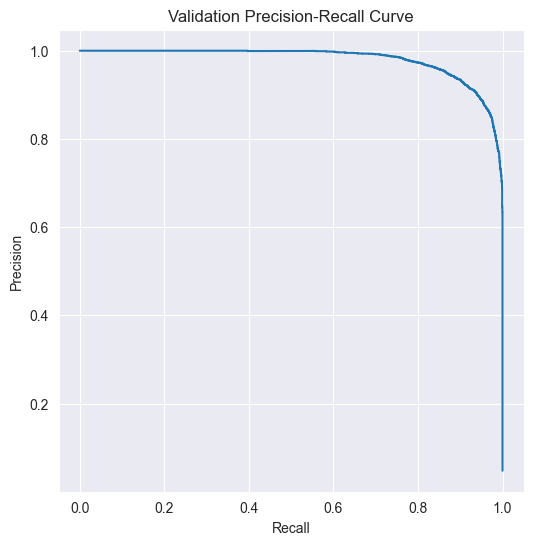

In [47]:
# Precision-Recall curve on validation set
y_val_prob = model.predict(X_val_scaled).ravel()
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_val, y_val_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals)
plt.title('Validation Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Best threshold = 0.35, Cost = 1077


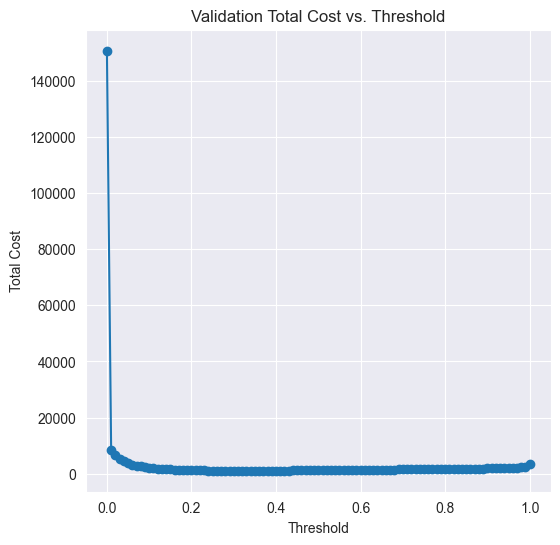

In [48]:
# Find cost-optimal threshold on validation set
def calculate_cost(thresh, y_true, y_prob, fp_cost=5, fn_cost=1):
    y_pred = (y_prob > thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * fp_cost + fn * fn_cost

thresholds = np.linspace(0, 1, 101)
costs = [calculate_cost(t, y_val, y_val_prob) for t in thresholds]

best_idx = np.argmin(costs)
best_thresh = thresholds[best_idx]
best_cost = costs[best_idx]
print(f"Best threshold = {best_thresh:.2f}, Cost = {best_cost}")

plt.figure(figsize=(6, 6))
plt.plot(thresholds, costs, marker='o')
plt.title('Validation Total Cost vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.show()

Using threshold = 0.35 for test evaluation
2335/2335 [==============================] - 2s 1ms/step


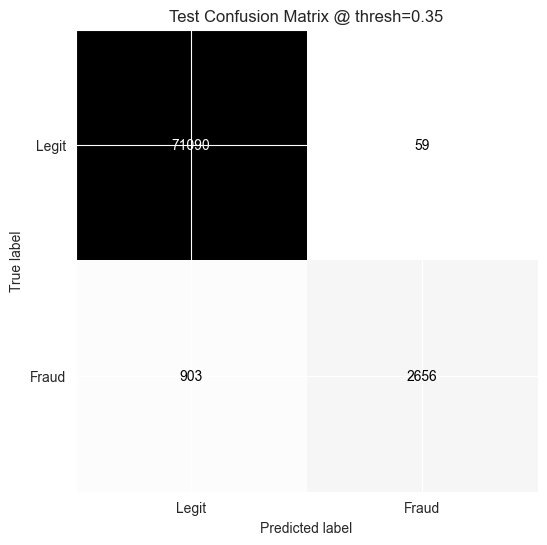

In [52]:
# Evaluate on test set using cost-optimal threshold
print(f"Using threshold = {best_thresh:.2f} for test evaluation")

y_test_prob = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_prob > best_thresh).astype(int)

# Confusion matrix (grayscale)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legit', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='gray_r', colorbar=False)
ax.set_title(f'Test Confusion Matrix @ thresh={best_thresh:.2f}')
plt.show()

In [53]:
# Metrics table on test set
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1 Score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_prob),
    'MCC': matthews_corrcoef(y_test, y_test_pred)
}

pd.DataFrame([metrics])

,Accuracy,Precision,Recall,F1 Score,ROC AUC,MCC
0,0.987123,0.978269,0.746277,0.846669,0.998856,0.848468


In [54]:
# Export the trained model
import os

# save as HDF5
export_path = '../Models/NeuralNetwork_Model.h5'
model.save(export_path)
print(f"Model exported to {export_path}")

Model exported to ../Models/NeuralNetwork_Model.h5
